### Must have `heainit` already running in the terminal window you're running this from!

This notebook assumes that you already have run the basic timing analysis and made a psd-cs-ccf file.

In [1]:
from astropy.table import Table, vstack, Column
from astropy import units as u
from astropy.io import fits
import numpy as np
import os
import subprocess
from xcor_tools_SwiftJ0243 import execute_shell_commands as shell
import matplotlib.pyplot as plt
from xcor_tools_SwiftJ0243 import find_nearest, pairwise, reshape_ccf
%matplotlib inline

In [23]:
homedir = os.path.expanduser('~')
obj_name = "Swift_J0243.6+6124"
obj_prefix = "J0243"
exe_dir = os.getcwd()
data_dir = '%s/Reduced_data/%s/' % (homedir, obj_name)
nsec = 64
dt_int = 2
which_rbn = 6
deadtime_file = exe_dir + "/in/obsid_113_folded_rate_exposure_deadtime_and_fraction2.txt"
shifted_deadtime_outfile = exe_dir + "/in/obsid_113_folded_deadtime_SHIFTED.fits"
ccf_file = exe_dir + "/out/J0243_%dsec_%ddt_ccf.fits" % (nsec, dt_int)
bkg_file = data_dir + "obs113_bkgd_rbn-%d.pha" % (which_rbn)
rmf_file = data_dir + "nicerv03_rbn-%d.rmf" % (which_rbn)
spec_file =  data_dir + "obs113_CI_tot_rbn-%d.pha" % (which_rbn)
out_dir = exe_dir + "/out/phase_spec"
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

assert os.path.isfile(deadtime_file), 'Deadtime file not found: %s' % deadtime_file
assert os.path.isfile(ccf_file), "CCF file not found: %s" % ccf_file
assert os.path.isfile(bkg_file), "Background file not found: %s" % bkg_file
assert os.path.isfile(rmf_file), "Response file not found: %s" % rmf_file
assert os.path.isfile(spec_file), 'Mean spectrum file not found: %s' % spec_file

In [16]:
t = Table.read(deadtime_file, format='ascii.commented_header', 
                 names=('Phase', 'Rate', 'Error', 'Exposure', 'Deadtime', 'DeadFrac'))
t['Phase'].unit = '%'
t['Rate'].unit = u.count/u.second
t['Error'].unit = u.count/u.second
t['Exposure'].unit = u.second
t['Deadtime'].unit = u.second
t['DeadFrac'].unit = '%'
t_len = len(t)
t.info

<Table length=100>
  name    dtype   unit 
-------- ------- ------
   Phase float64      %
    Rate float64 ct / s
   Error float64 ct / s
Exposure float64      s
Deadtime float64      s
DeadFrac float64      %

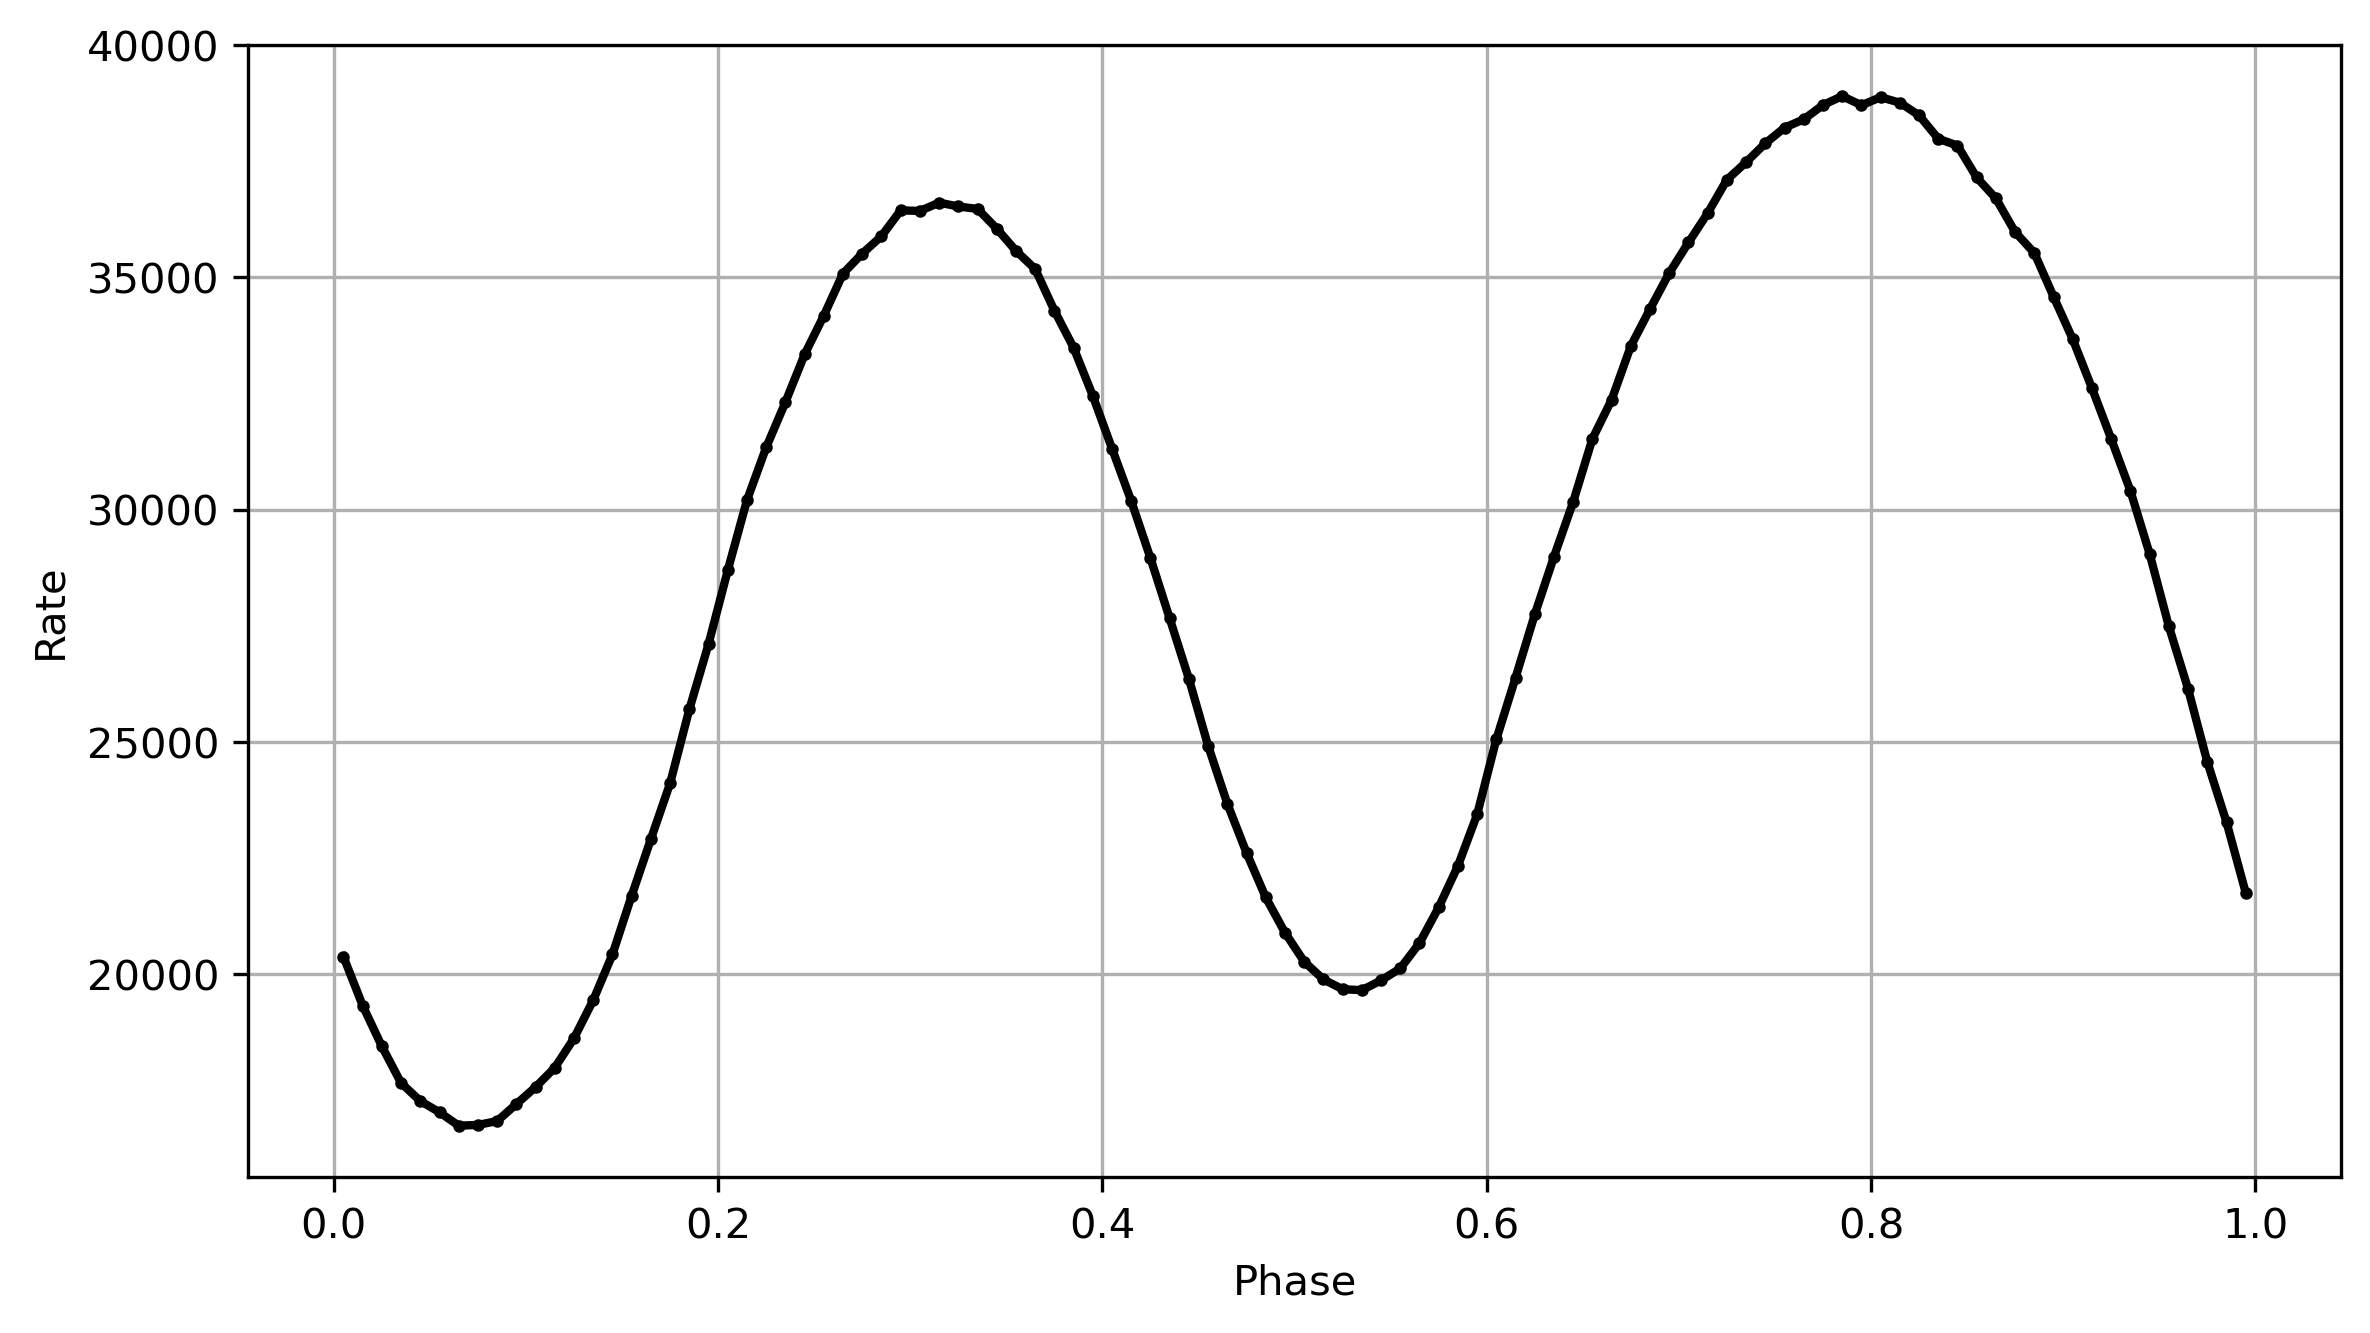

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), dpi=300)
# ax.hlines(0.0, t_min, t_max, lw=2, color='black', linestyle='dashed')
ax.plot(t['Phase'], t['Rate'], lw=2, markerfacecolor='none', markeredgecolor='black',
            color='black', marker='o', ms=2,)
# ax.vlines(p0_tbin, -5000, 6600, lw=1, color='blue')
# ax.set_ylim(-5000, 6600)
# ax.set_xlim(t_min, t_max)
ax.set_xlabel(r'Phase')
ax.set_ylabel(r'Rate')
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_axisbelow(True)
plt.show()

In [19]:
ccf_tab = Table.read(ccf_file, format='fits')
rate_ci = np.asarray(ccf_tab.meta['RATE_CI'][1:-1].split(','), dtype='float')
ccf_tab.info
n_bins = ccf_tab.meta['N_BINS']

## Pick a starting phase of ccf_tab
Using the fundamental max (but not the 0 'bin')

In [20]:
# reshape ccf
t_min = -20
t_max = 0
## don't want to use positive time delay bins because I don't want to do mirroring
t_bins, new_ccf, new_err = reshape_ccf(ccf_tab['CCF'], ccf_tab['CCF_ERR'], n_bins)
bin_mask = (t_bins >= t_min) & (t_bins <= t_max)
new_ccf = new_ccf[bin_mask]
t_bins = t_bins[bin_mask]
# sum ccf across energies
sum_ccf = np.sum(new_ccf, axis=1)
print(np.shape(sum_ccf))
# find max (or min?) in a narrow range
p0_idx = np.argmax(sum_ccf[0:10])
p0_tbin = t_bins[p0_idx]
# that is the starting bin
print(p0_tbin)

(21,)
-20


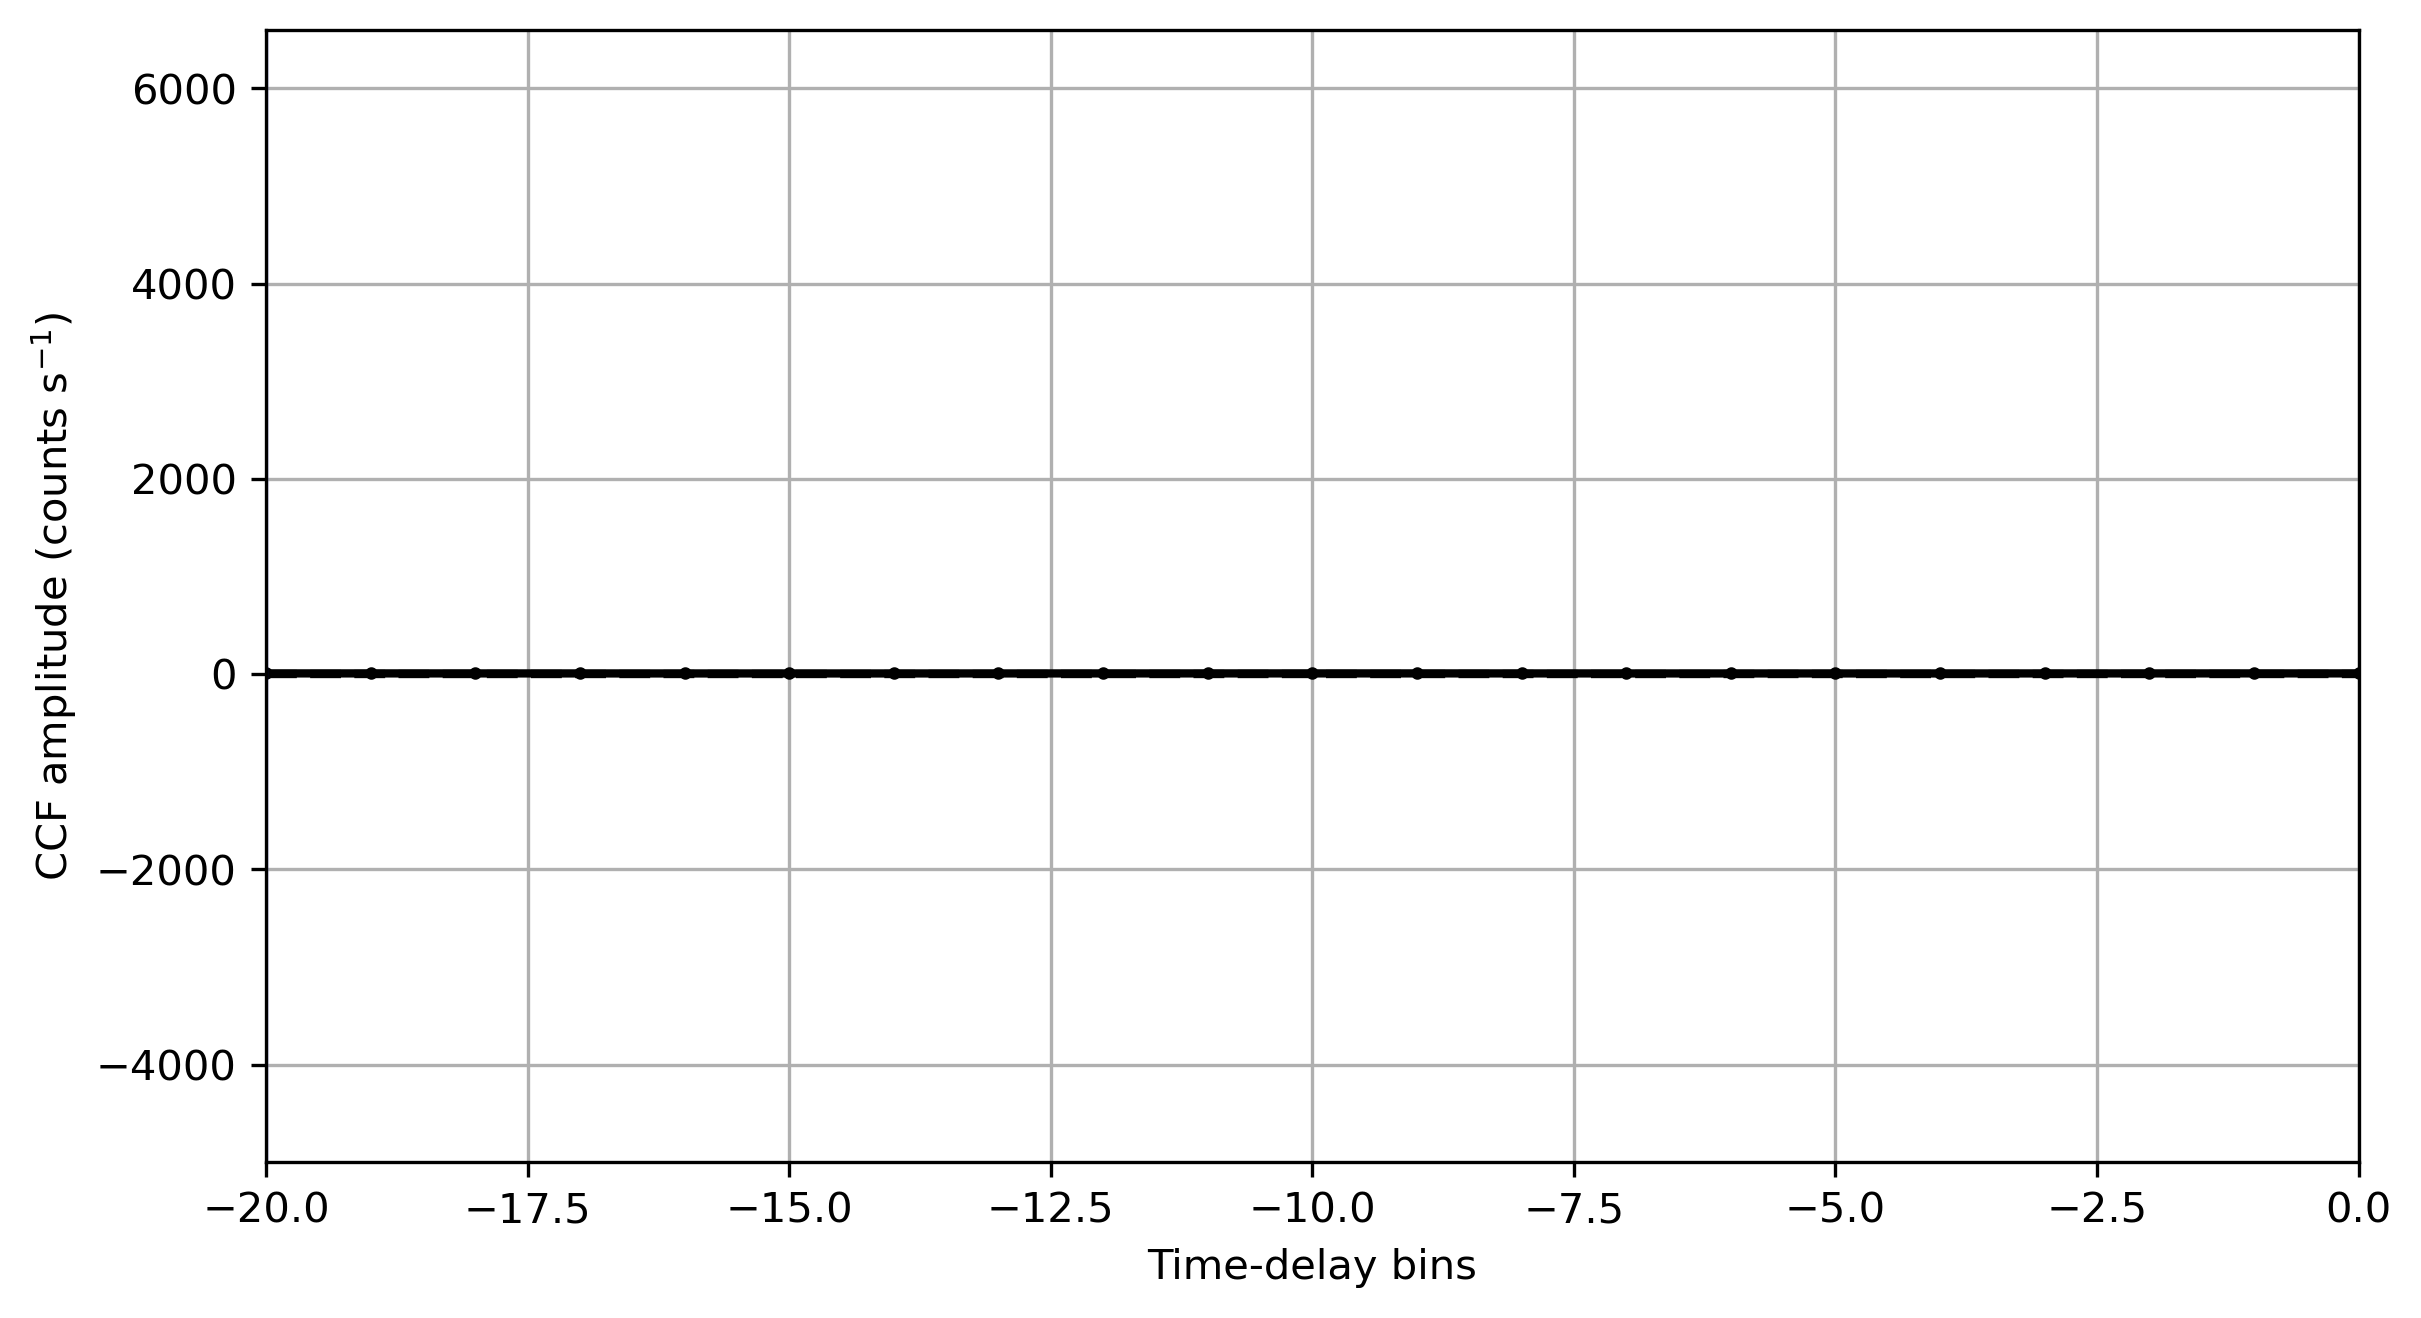

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), dpi=300)
ax.hlines(0.0, t_min, t_max, lw=2, color='black', linestyle='dashed')
ax.plot(t_bins, sum_ccf, lw=2, markerfacecolor='none', markeredgecolor='black',
            color='black', marker='o', ms=2,)
ax.vlines(p0_tbin, -5000, 6600, lw=1, color='blue')
ax.set_ylim(-5000, 6600)
ax.set_xlim(t_min, t_max)
ax.set_xlabel(r'Time-delay bins')
ax.set_ylabel(r'CCF amplitude (counts s$^{-1}$)')
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_axisbelow(True)
plt.show()

## Figure out what that starting phase is in t['Phase']

In [22]:
start_phase = np.argmax(t['Rate'])  # index of CCF 'starting point' is maximum
print(start_phase)
## shift t so that t[0] and ccf_tab[0] have the same phase
new_t = vstack([t[start_phase:t_len], t[0:start_phase]])
new_t.add_column(Column(data=np.arange(0,1.0,1/100), name='Phase_shifted'))
new_t.info

78


<Table length=100>
     name      dtype   unit 
------------- ------- ------
        Phase float64      %
         Rate float64 ct / s
        Error float64 ct / s
     Exposure float64      s
     Deadtime float64      s
     DeadFrac float64      %
Phase_shifted float64       

In [9]:
# fig, ax = plt.subplots(1, 1, figsize=(9, 5), dpi=300)
# ax.plot(new_t['Phase_shifted'], new_t['DeadFrac'])
# plt.show()

In [10]:
new_t.write(shifted_deadtime_outfile, format='fits', overwrite=True)

In [11]:
## Use time bins -whatever to 0, so that I don't have to do any mirroring. 
## As show in simulate.ipynb, the trough depths changes are intrinsic, not due to the ccf.
## Since I quote RMS values in the paper, it should be ok.

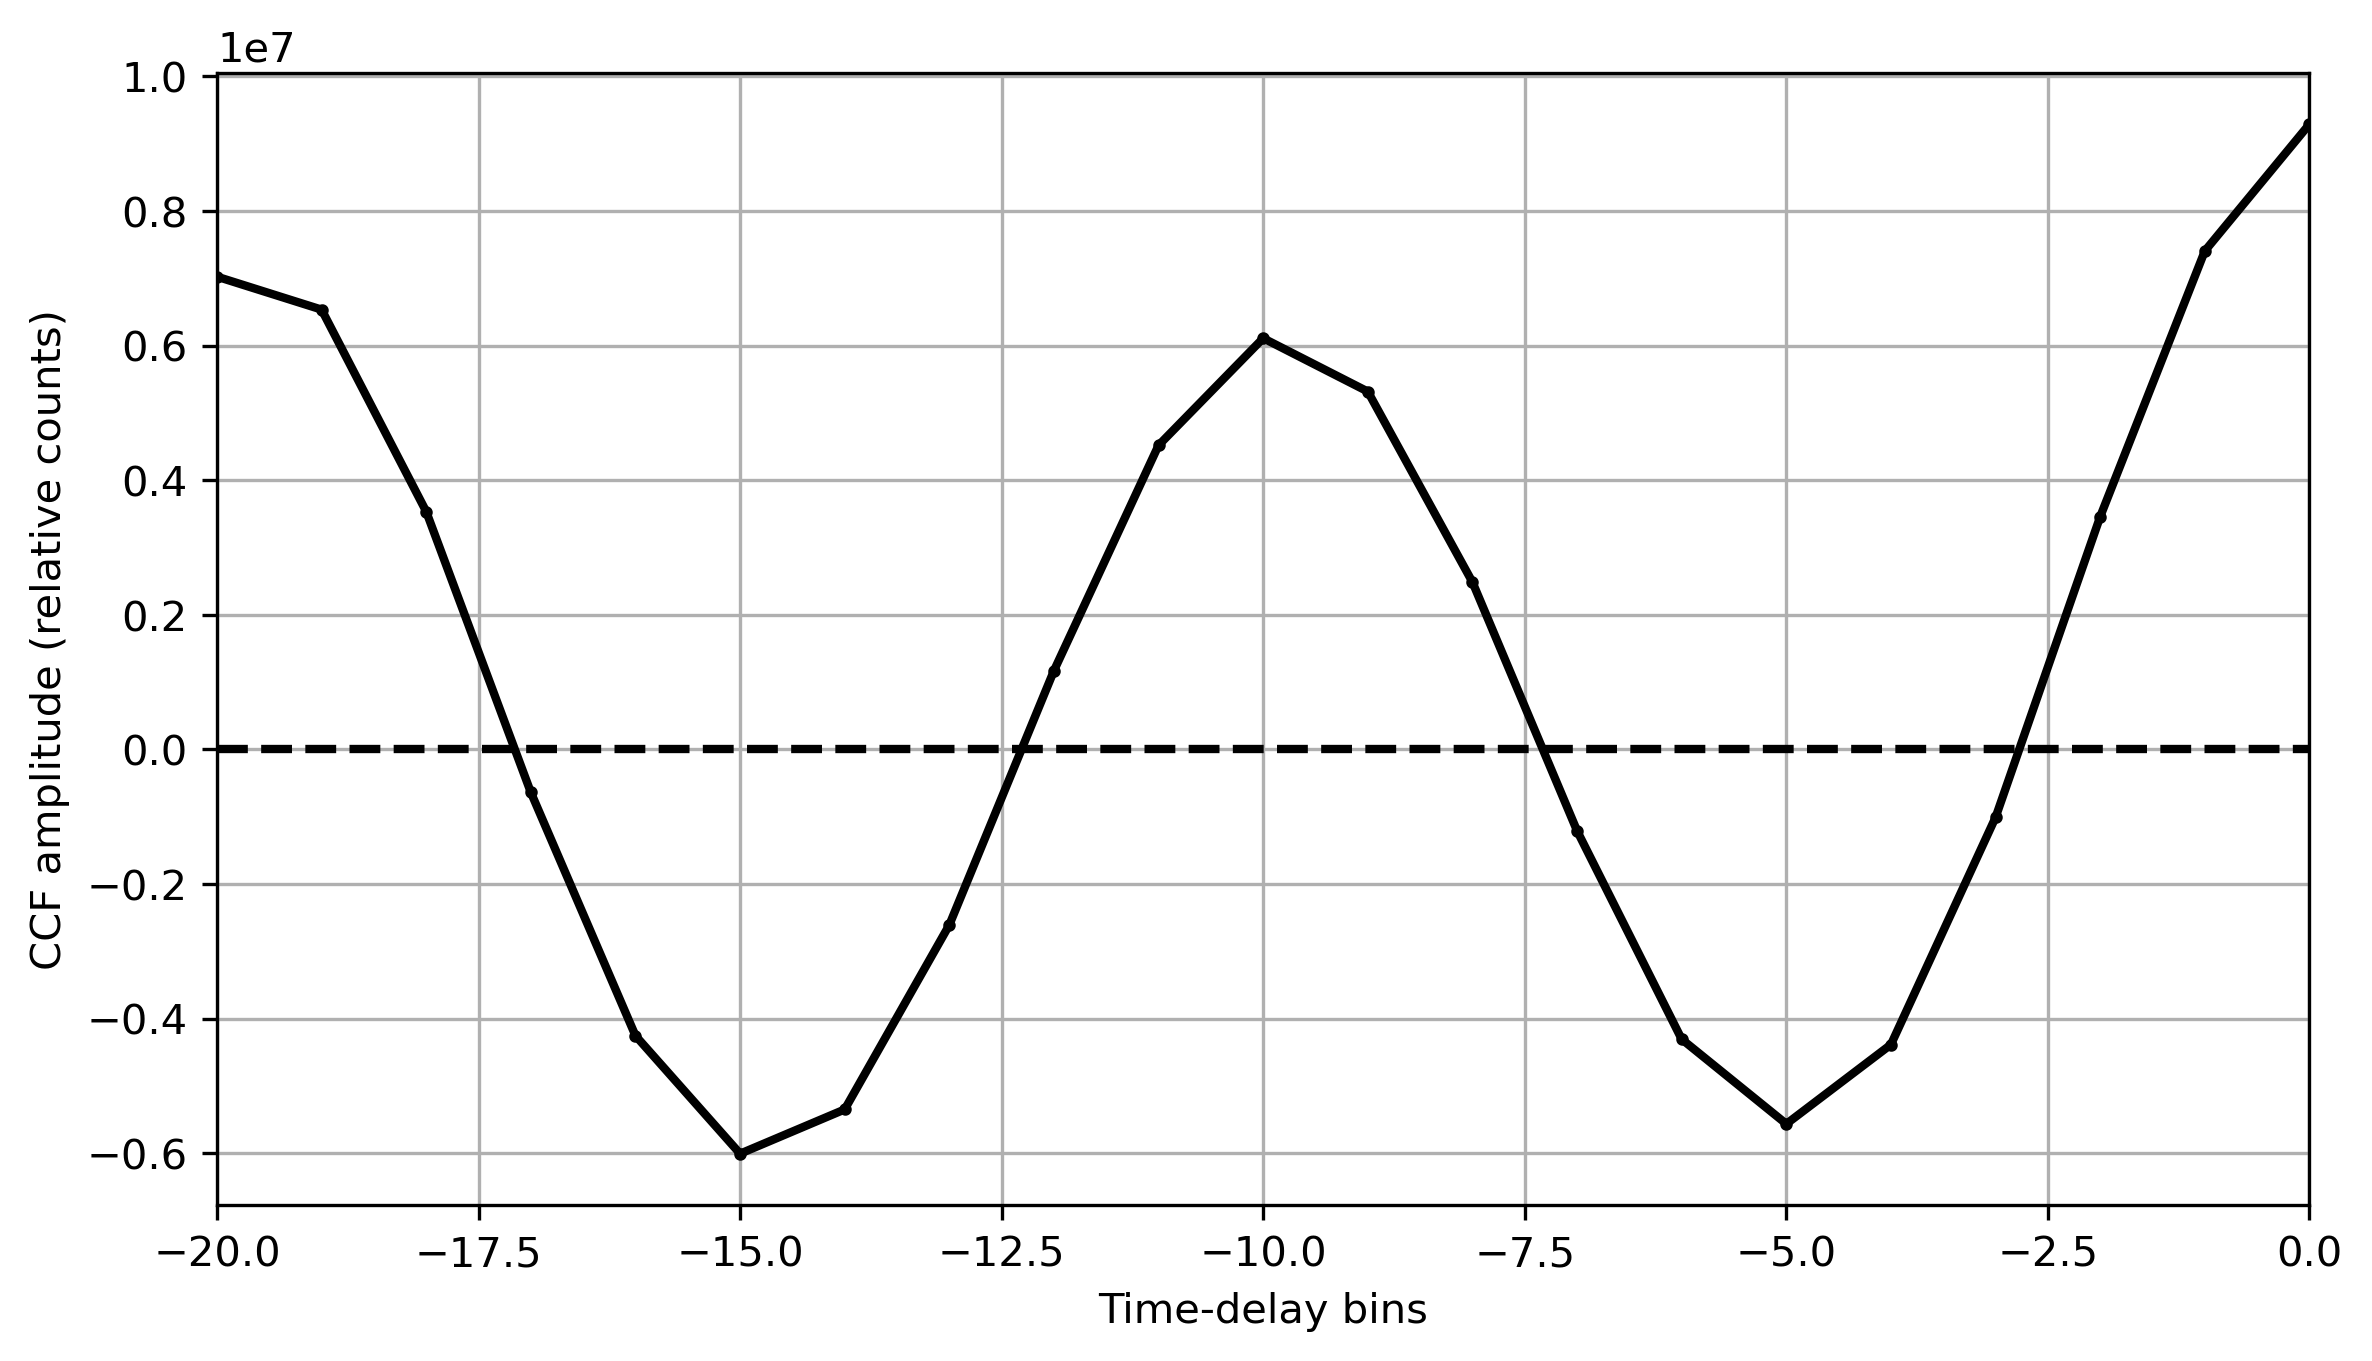

In [12]:
## multiply ccf by exposure time in file to get counts
ccf_counts = new_ccf * ccf_tab.meta['EXPOSURE']  # now in counts
t_ccf = sum_ccf * ccf_tab.meta['EXPOSURE']
corr_exp = np.zeros(np.shape(ccf_counts)[0])
for i in range(np.shape(t_ccf)[0]):
    this_phase = i / 20.
    close_phase, close_idx = find_nearest(new_t['Phase_shifted'], this_phase)
#     print(this_phase, close_phase, new_t['DeadFrac'][close_idx])
    corr_exp[i] = ccf_tab.meta['EXPOSURE'] * (1-new_t['DeadFrac'][close_idx])
#     print(ccf_tab.meta['EXPOSURE'], corr_exp[i])
    ## TODO: when I get the real deadtime curve from colleen, corr_exp[i] = exposure - deadtime[i]

# temp_ccf = t_ccf / corr_exp
# corr_ccf = ccf_counts / corr_exp[:,np.newaxis]
# ##but use deadtime-corrected exposure time for next steps (keep in counts)
# ## leave in units of counts for spectrum part

fig, ax = plt.subplots(1, 1, figsize=(9, 5), dpi=300)
ax.hlines(0.0, t_min, t_max, lw=2, color='black', linestyle='dashed')
ax.plot(t_bins, t_ccf, lw=2, markerfacecolor='none', markeredgecolor='black',
            color='black', marker='o', ms=2,)
# ax.vlines(p0_tbin, -5000, 6600, lw=1, color='blue')
# ax.set_ylim(-5000, 6600)
ax.set_xlim(t_min, t_max)
ax.set_xlabel(r'Time-delay bins')
ax.set_ylabel(r'CCF amplitude (relative counts)')
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_axisbelow(True)
plt.show()

In [13]:
## apply general deadtime correction to mean rate 
mean_goodfrac = (3126./4566.) # from table 1 in Wilson-Hodge+18
## correct mean rate for deadtime
mean_correxp = ccf_tab.meta['EXPOSURE']*mean_goodfrac
rate_ci_corr = rate_ci * ccf_tab.meta['EXPOSURE'] / mean_correxp
print(rate_ci[20:30])
print(rate_ci_corr[20:30])

[ 3.80989575  4.80403662  6.06184912  7.56640625  9.03776073 10.76041698
 12.84960938 15.49934864 18.45833397 21.55729103]
[ 5.5649341   7.01702853  8.85425562 11.05189089 13.20102864 15.71723095
 18.76881523 22.63916375 26.96121334 31.487713  ]


# Read in mean spectrum of CI

In [14]:
spec_tab = Table.read(spec_file, format='fits', hdu=1)
print(spec_tab.columns)
# ## apply deadtime correction (subsuming the mean spectrum program in this notebook)
spec_tab.meta['EXPOSURE'] = spec_tab.meta['EXPOSURE'] * mean_goodfrac

<TableColumns names=('CHANNEL','COUNTS','QUALITY')>


In [15]:
## make total phase spectra (average CI spectrum plus phase-resolved deviation from mean)
tot_phase_spec = ccf_counts + spec_tab['COUNTS']
print(np.shape(tot_phase_spec))

(21, 294)


In [16]:
bkg = Table.read(bkg_file, format='fits', hdu=1)
print(bkg)

CHANNEL COUNTS QUALITY
          ct          
------- ------ -------
      0      0       0
      1      0       0
      2  16151       0
      3  19379       0
      4  10226       0
      5   5480       0
      6   3377       0
      7   1949       0
      8   1202       0
      9    861       0
    ...    ...     ...
    284    310       0
    285    289       0
    286    282       0
    287    299       0
    288    320       0
    289    387       0
    290    337       0
    291    311       0
    292    303       0
    293    287       0
Length = 294 rows


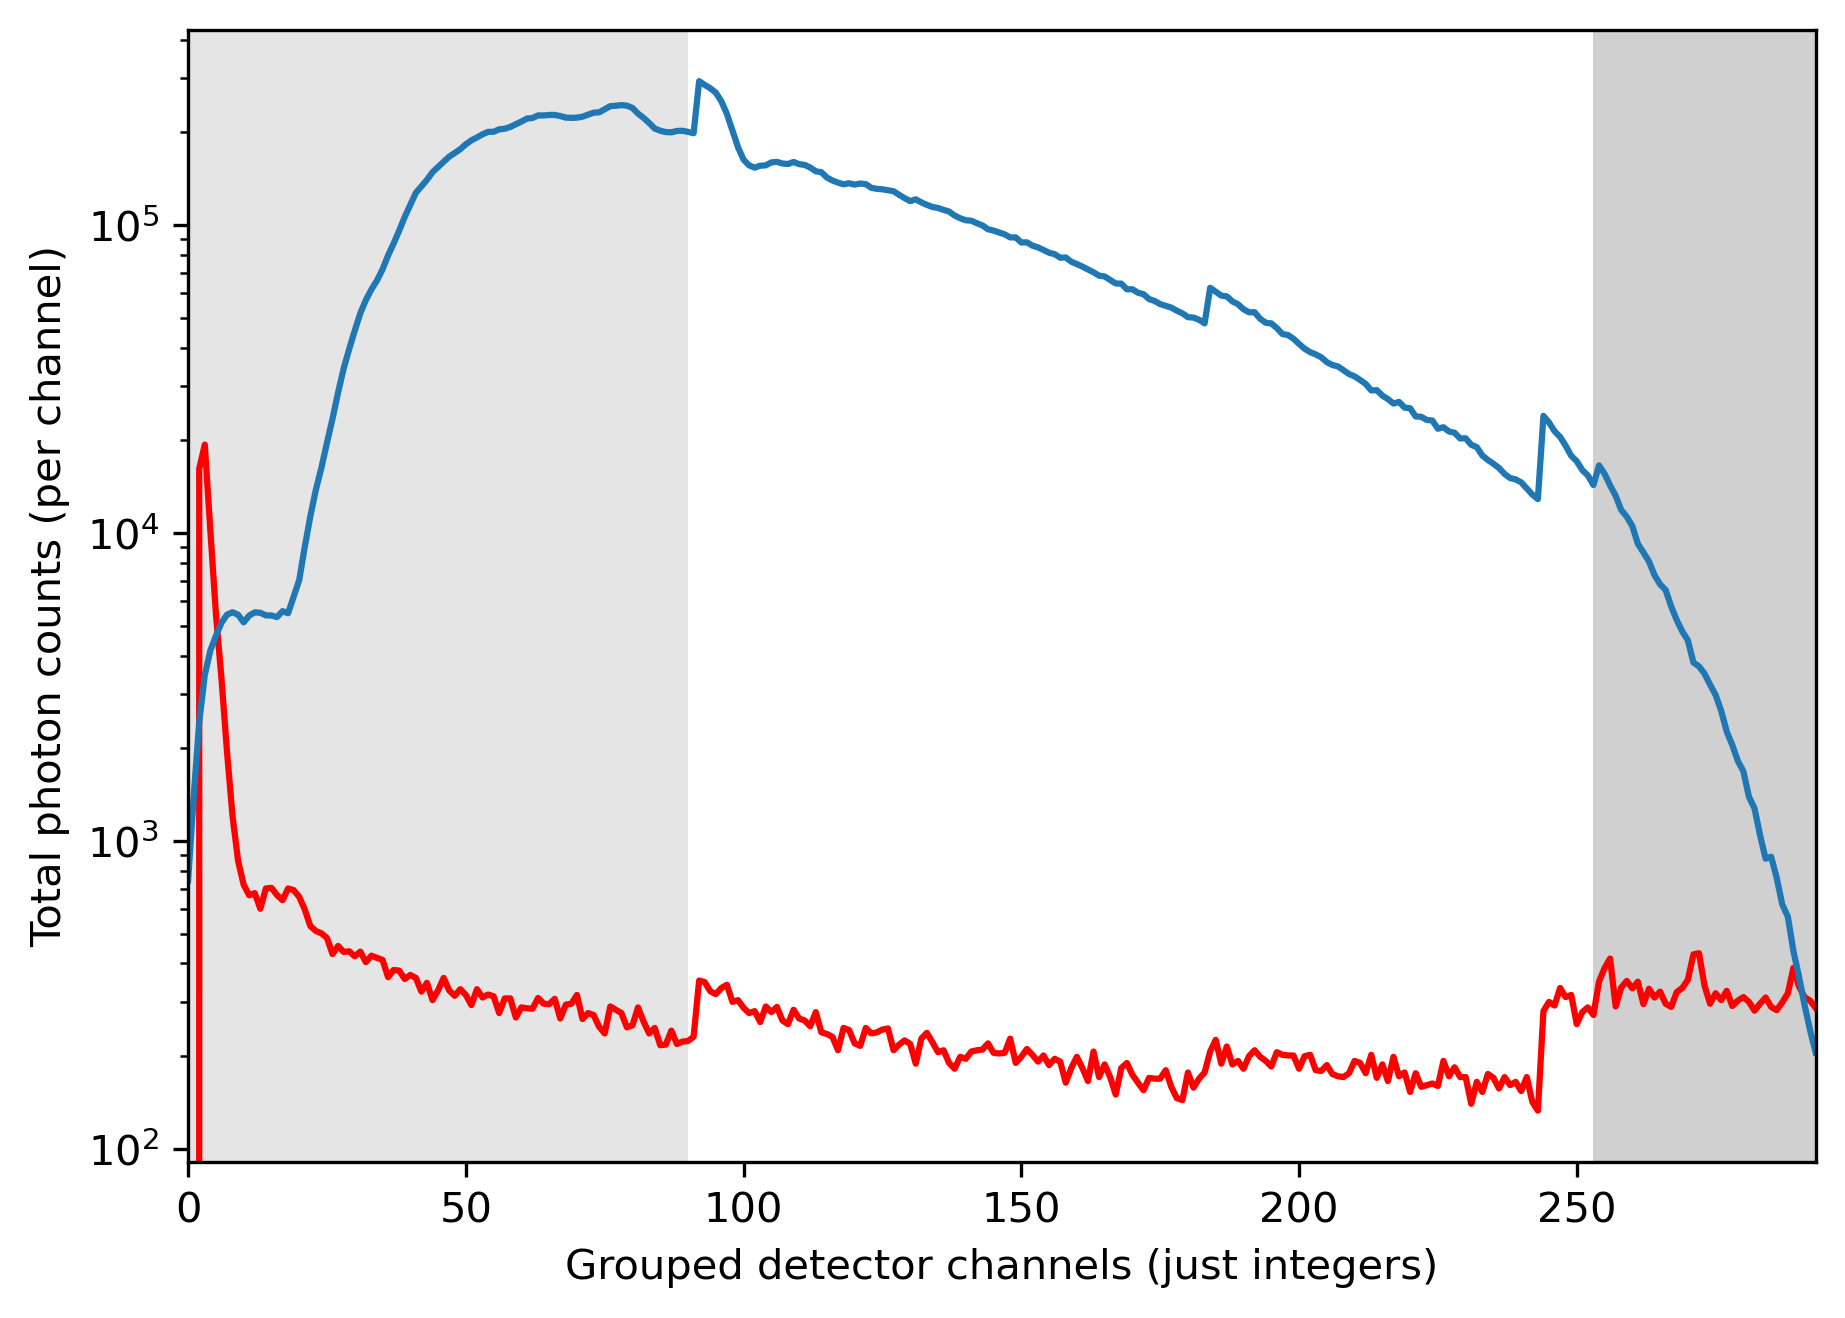

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)
ax.plot(bkg['CHANNEL'], bkg['COUNTS'], color='red')
ax.plot(bkg['CHANNEL'], tot_phase_spec[0,:])
ax.set_yscale('log')
ax.set_xlabel('Grouped detector channels (just integers)')
ax.set_ylabel('Total photon counts (per channel)')
ax.set_xlim(0,293)
plt.axvspan(0, 90, ymin=0, ymax=1, facecolor='gray', alpha=0.2)
plt.axvspan(253, 293, ymin=0, ymax=1, facecolor='gray', alpha=0.2)
plt.axvspan(253, 293, ymin=0, ymax=1, facecolor='gray', alpha=0.2)
plt.savefig('spectra_and_bkgd.png')
plt.show()

In [21]:
print(tot_phase_spec[0,100:110])
tot_phase_spec = np.array(np.round(tot_phase_spec), dtype=int)
print(tot_phase_spec[0,100:110])

[163149.05355248 156351.32095989 153751.98433117 156003.83618542
 156415.03004329 159891.50715945 160617.64410892 158559.5919161
 158015.2420857  160403.73912741]
[163149 156351 153752 156004 156415 159892 160618 158560 158015 160404]


In [22]:
## Not doing anything to the response, 
## but need to multiply whole model by CONST=52./NUM_FPMs (which is 27 for obsID *13 of J0243), 
## and also adjust the normalizations of each model by 1/CONST

In [25]:
## write out with corr_exp, the corrected exposure time. 
## Need new file for each, since they all have different exposures
## use response and background header keywords when writing out the total phase spectra tables
# print("heainit")
# shell(['heainit'])
curr_dir = os.getcwd()
# print("cd %s" % out_dir)
os.chdir(out_dir)

chan_arr = np.arange(ccf_tab.meta['N_CHANS'])
for row in np.arange(np.shape(tot_phase_spec)[0]):
    print(row)
    phspec_out_file = out_dir + "/J0243_%dsec_%ddt_corr_%d.txt" % (nsec, dt_int, row)
    corr_exposuretime = rate_ci_corr[row] + spec_tab.meta['EXPOSURE']
    np.savetxt(phspec_out_file, tot_phase_spec[row,:])
    ascii2pha = ["ascii2pha",
                 "infile=J0243o13_%dsec_%ddt_corr_%d.txt" % (nsec, dt_int, row),
                 "outfile=J0243o13_%dsec_%ddt_corr_%d.pha " % (nsec, dt_int, row),
                 "chanpres=N ",
                 "chantype=PI ",  # PHA means hasn't been changed at all since recorded; ours have been binned
                 "dtype=1 ",  # for counts
                 "qerror=N ",
                 "rows=- ",
                 "fchan=0 ",
                 "tlmin=0 ",
                 "detchans=%d " % ccf_tab.meta['N_CHANS'],
                 "pois=Yes ",  # if Dtype isn't counts, it won't let you set Poiss=True
                 "telescope=NICER ",
                 "instrume=XTI ",
                 "detnam=MPU0123 ",
                 "filter='NONE' ",
                 "exposure=%f " % corr_exposuretime,
                 "backfile=%s " % os.path.relpath(bkg_file, start=out_dir),
                 "respfile=%s " % os.path.relpath(rmf_file, start=out_dir),
                 "clobber=Y"]
    shell(ascii2pha)
    
os.chdir(curr_dir)

0
b' Main ASCII2PHA Ver 1.2.0\n ... written the PHA data Extension\n ASCI2FPHA Ver 1.2.0 completed\n'
1
b' Main ASCII2PHA Ver 1.2.0\n ... written the PHA data Extension\n ASCI2FPHA Ver 1.2.0 completed\n'
2
b' Main ASCII2PHA Ver 1.2.0\n ... written the PHA data Extension\n ASCI2FPHA Ver 1.2.0 completed\n'
3
b' Main ASCII2PHA Ver 1.2.0\n ... written the PHA data Extension\n ASCI2FPHA Ver 1.2.0 completed\n'
4
b' Main ASCII2PHA Ver 1.2.0\n ... written the PHA data Extension\n ASCI2FPHA Ver 1.2.0 completed\n'
5
b' Main ASCII2PHA Ver 1.2.0\n ... written the PHA data Extension\n ASCI2FPHA Ver 1.2.0 completed\n'
6
b' Main ASCII2PHA Ver 1.2.0\n ... written the PHA data Extension\n ASCI2FPHA Ver 1.2.0 completed\n'
7
b' Main ASCII2PHA Ver 1.2.0\n ... written the PHA data Extension\n ASCI2FPHA Ver 1.2.0 completed\n'
8
b' Main ASCII2PHA Ver 1.2.0\n ... written the PHA data Extension\n ASCI2FPHA Ver 1.2.0 completed\n'
9
b' Main ASCII2PHA Ver 1.2.0\n ... written the PHA data Extension\n ASCI2FPHA Ver

# these are now used in phspec_fit_mod1.sh

In [ ]:
 #     phspec_tab['CHANNEL'].unit = 'chan'
#     phspec_tab['COUNTS'].unit = 'count'
    # make sure files are local to exe_dir + "/out/phase_spec"
#     phspec_tab.meta['EXTNAME'] = 'SPECTRUM'
#     phspec_tab.meta['HDUCLAS1'] = 'SPECTRUM'
#     phspec_tab.meta['HDUCLAS2'] = 'TOTAL'
#     phspec_tab.meta['HDUCLAS3'] = 'COUNT'
#     phspec_tab.meta['TELESCOP'] = 'NICER'
#     phspec_tab.meta['INSTRUME'] = 'XTI'
#     phspec_tab.meta['EXPOSURE'] = rate_ci_corr[row] + spec_tab.meta['EXPOSURE']
#     phspec_tab.meta['BACKFILE'] = os.path.relpath(bkg_file, start=out_dir)
#     phspec_tab.meta['RESPFILE'] = os.path.relpath(rmf_file, start=out_dir)
#     phspec_tab.meta['DETCHANS'] = ccf_tab.meta['N_CHANS']
#     phspec_tab.meta['POISSERR'] = True
#     phspec_tab.meta['SYS_ERR'] = 0
#     phspec_tab.meta['STAT_ERR'] = 0
#     phspec_tab.meta['GROUPING'] = 0
#     phspec_tab.meta['DATAMODE'] = 'PHOTON'
#     phspec_tab.meta['OBS_ID'] = '1050390113'
#     phspec_tab.meta['TARG_ID'] = 1122
#     phspec_tab.meta['OBJECT'] = 'Swift_J0243.6+6124'
#     phspec_tab.write(phspec_out_file, format='text', overwrite=True)

